# Support Vector Machine

### 0. Data Preparation

In [1]:
import numpy as np
import pandas as pd
import cvxopt as cp
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn import svm
import evaluate

In [2]:
warnings.filterwarnings('ignore')

train = pd.read_csv('Dataset/train_preprocessing.csv')
test = pd.read_csv('Dataset/test_preprocessing.csv')
gender_submission = pd.read_csv('Dataset/gender_submission.csv')
# Merge the test dataframe with the gender_submission dataframe on 'PassengerId'
test = pd.merge(test, gender_submission[['PassengerId', 'Survived']], on='PassengerId', how='left')
test = test.drop(['Survived_x'], axis = 1)
test.rename(columns={'Survived_y': 'Survived'}, inplace=True)
print(test.head())
train = train[train['Survived'] != 'U']
test = test[test['Survived'] != 'U']
validation, test = train_test_split(test, test_size=2/3, random_state=42)

   Unnamed: 0  index  PassengerId  Pclass  \
0         893      2          894       2   
1         894      3          895       3   
2         895      4          896       3   
3         896      5          897       3   
4         897      6          898       3   

                                           Name  Sex   Age  SibSp  Parch  \
0                     Myles, Mr. Thomas Francis    1  62.0      0      0   
1                              Wirz, Mr. Albert    1  27.0      0      0   
2  Hirvonen, Mrs. Alexander (Helga E Lindqvist)    0  22.0      1      1   
3                    Svensson, Mr. Johan Cervin    1  14.0      0      0   
4                          Connolly, Miss. Kate    0  30.0      0      0   

    Ticket     Fare  Cabin  Embarked  Title  Survived  
0   240276   9.6875      8         1      2         0  
1   315154   8.6625      8         2      2         0  
2  3101298  12.2875      8         2      3         1  
3     7538   9.2250      8         2      2     

In [3]:
X_train = train[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']].values
Y_train = train[['Survived']].values
X_test = test[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']].values
Y_test = test[['Survived']].values
X_valid = validation[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Title']].values
Y_valid = validation[['Survived']].values
Y_train[Y_train == '0.0'] = -1
Y_train[Y_train == '1.0'] = 1
Y_test[Y_test == 0] = -1
Y_valid[Y_valid == 0] = -1

### 1. Scikit-Learn

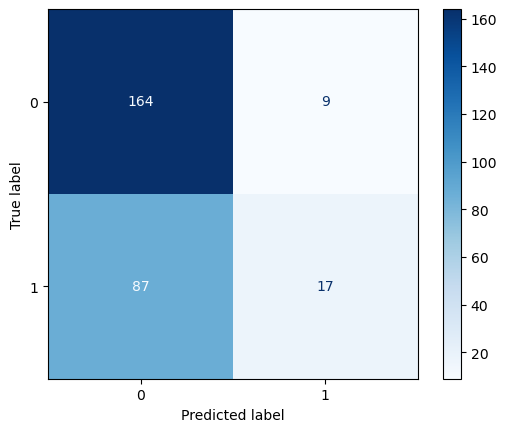

Accuracy: 0.6534296028880866
Precision: 0.6535590490025458
Recall: 0.6534296028880866
F1 Score: 0.5813364212247122


In [4]:
y_train_lib = train[['Survived']].values
y_test_lib = test[['Survived']].values
y_valid_lib = validation[['Survived']].values
model = svm.SVC(kernel='poly', C=0.5)
model.fit(X_train, y_train_lib)
Y_pred = model.predict(X_test)
evaluate.evaluate(y_test_lib, Y_pred.astype(float), 1)

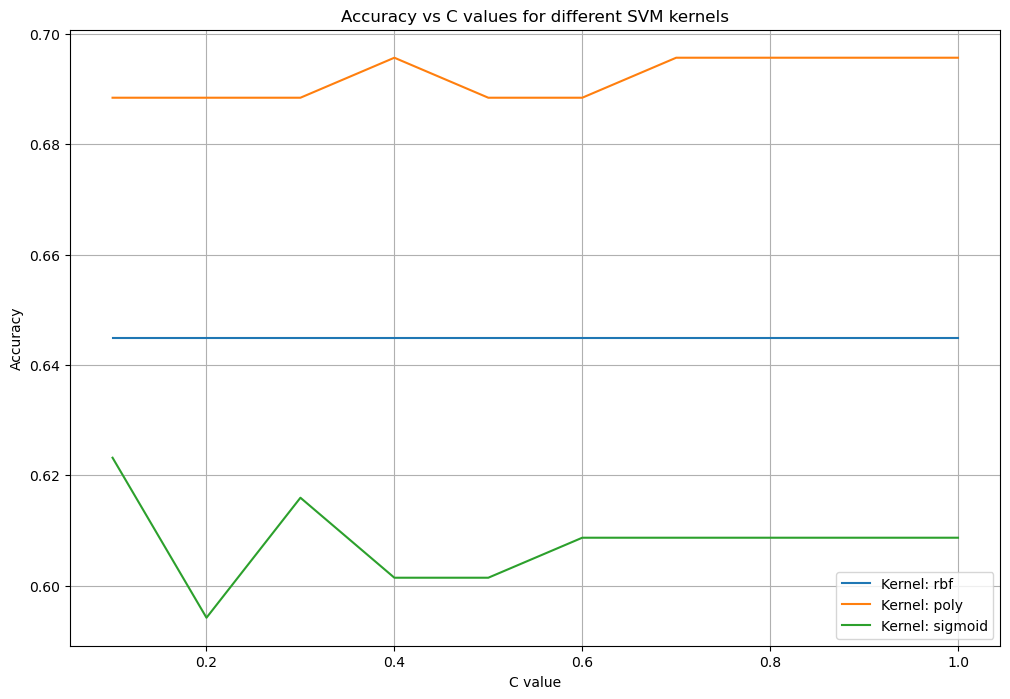

poly


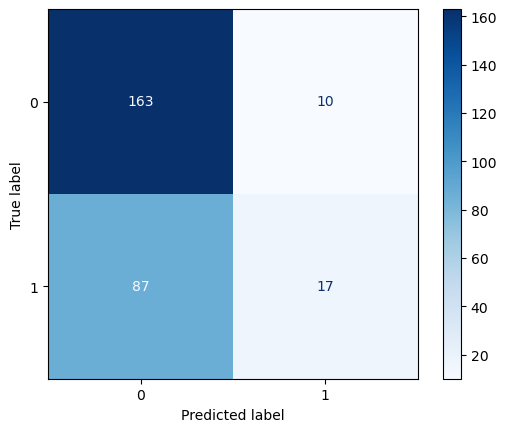

Accuracy: 0.6498194945848376
Precision: 0.6436010161786335
Recall: 0.6498194945848376
F1 Score: 0.5787760708056295


In [17]:
# Tuning
kernels = ['rbf', 'poly', 'sigmoid']
c_values = np.arange(0.1, 1.1, 0.1)
max_acc = 0
best_model = None
best_kernel = None

# Initialize a dictionary to store the accuracy results
accuracy_results = {kernel: [] for kernel in kernels}

for kernel in kernels:
    for C in c_values:
        model = svm.SVC(kernel=kernel, C=C)
        model.fit(X_train, y_train_lib)
        Y_pred = model.predict(X_valid)
        acc_tmp = accuracy_score(y_valid_lib, Y_pred.astype(float))
        accuracy_results[kernel].append(acc_tmp)
        if acc_tmp > max_acc:
            max_acc = acc_tmp
            best_model = model
            best_kernel = kernel

# Plot the results
plt.figure(figsize=(12, 8))
for kernel in kernels:
    plt.plot(c_values, accuracy_results[kernel], label=f'Kernel: {kernel}')

plt.title('Accuracy vs C values for different SVM kernels')
plt.xlabel('C value')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Y_pred = best_model.predict(X_test)
print(best_kernel)
evaluate.evaluate(y_test_lib, Y_pred.astype(float), 1)

### 2. CVXPY

In [8]:
class SVM:
    def __init__(self, C=1.0):
        self.C = C
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Define the variables
        w = cp.Variable(n_features)
        b = cp.Variable()
        xi = cp.Variable(n_samples)

        # Define the constraints
        constraints = [y[i] * (X[i] @ w + b) >= 1 - xi[i] for i in range(n_samples)]
        constraints += [xi >= 0]

        # Define the objective function
        objective = cp.Minimize(0.5 * cp.norm(w, 2)**2 + self.C * cp.sum(xi))

        # Define the problem
        problem = cp.Problem(objective, constraints)

        # Solve the problem
        problem.solve()

        # Store the parameters
        self.w = w.value
        self.b = b.value

    def predict(self, X):
        return np.sign(X @ self.w + self.b)

In [ ]:
Y_train_lib = train
model = SVM()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
evaluate(Y_test, Y_pred, 1)